<a href="https://colab.research.google.com/github/Viny2030/tensorflow/blob/main/text_classification_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

Clasificación de texto con una red neuronal recurrente
Ver en TensorFlow.org Ejecutar en Google Colab Ver código fuente en GitHub Descargar notebook
Este tutorial de clasificación de texto entrena una red neuronal recurrente en el gran conjunto de datos de reseñas de películas de IMDB para el análisis de sentimientos.

## Setup

In [1]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

Import `matplotlib` and create a helper function to plot graphs:

Importa matplotlib y crea una función auxiliar para trazar gráficos:

In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


# Configurar el flujo de entrada
El conjunto de datos de reseñas de películas de gran tamaño de IMDB es un conjunto de datos de clasificación binaria: todas las reseñas tienen un sentimiento positivo o negativo.

Descargue el conjunto de datos mediante TFDS. Consulte el tutorial de carga de texto para obtener detalles sobre cómo cargar este tipo de datos manualmente.

[ ]

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [24]:
dataset

{Split('train'): <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 Split('test'): <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 Split('unsupervised'): <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}

Initially this returns a dataset of (text, label pairs):

Inicialmente, esto devuelve un conjunto de datos de (pares de texto y etiqueta):

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next shuffle the data for training and create batches of these `(text, label)` pairs:

A continuación, mezcle los datos para el entrenamiento y cree lotes de estos pares (texto, etiqueta):

In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [6]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [7]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'I screamed my head off because seeing this movie was my first movie going experience ever at some 13 months old. I remember it being incredibly bloody and it made me angry. I watched it again on tv a few years ago. Big mistake -- the acting is wooden, the plot non-existent and the movie lacks merit unless 23 year-old T & A is what gets you going... 0/****'
 b"Being a fan of the manga and anime of Go Nagai (DEVIL MAN, DEVIL LADY, VIOLENCE JACK, etc.), I was looking forward to this one. I'd seen neither the manga nor the anime, so I had no preconceived notions going in. Good thing, too. What we have here is a series of silly softcore movies of the type that used to turn up with alarming regularity on cable channels late at night. While it's tame compared to what gets rammed down the throats of regular cable viewers (our hero's naughty bits are either tastefully tucked away behind a strategically glued-on scarf or emblazoned with a ridiculous sunburst effect), there are prolong

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

# **Crear el codificador de texto**
El texto sin procesar cargado por tfds debe procesarse antes de poder usarse en un modelo. La forma más sencilla de procesar texto para el entrenamiento es mediante la capa TextVectorization. Esta capa tiene muchas capacidades, pero este tutorial se atiene al comportamiento predeterminado.

Cree la capa y pase el texto del conjunto de datos al método .adapt de la capa:

In [8]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

El método .adapt establece el vocabulario de la capa. Aquí están los primeros 20 tokens. Después del relleno y los tokens desconocidos, se ordenan por frecuencia:

[ ]

In [9]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

Una vez que se establece el vocabulario, la capa puede codificar texto en índices. Los tensores de los índices se rellenan con ceros hasta la secuencia más larga del lote (a menos que establezca una longitud de secuencia de salida fija):

In [10]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 10,   1,  56, ...,   0,   0,   0],
       [107,   4, 331, ...,   0,   0,   0],
       [ 10, 208,   2, ...,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

Con la configuración predeterminada, el proceso no es completamente reversible. Existen tres razones principales para ello:

El valor predeterminado para el argumento de estandarización de preprocessing.TextVectorization es "lower_and_strip_punctuation".
El tamaño limitado del vocabulario y la falta de una alternativa basada en caracteres dan como resultado algunos tokens desconocidos.

In [11]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'I screamed my head off because seeing this movie was my first movie going experience ever at some 13 months old. I remember it being incredibly bloody and it made me angry. I watched it again on tv a few years ago. Big mistake -- the acting is wooden, the plot non-existent and the movie lacks merit unless 23 year-old T & A is what gets you going... 0/****'
Round-trip:  i [UNK] my head off because seeing this movie was my first movie going experience ever at some [UNK] [UNK] old i remember it being incredibly [UNK] and it made me [UNK] i watched it again on tv a few years ago big [UNK] the acting is [UNK] the plot [UNK] and the movie [UNK] [UNK] unless [UNK] [UNK] [UNK] a is what gets you going [UNK]                                                                                                                                                                                                                                                                                       

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

Above is a diagram of the model.

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output.

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output.


Arriba hay un diagrama del modelo.

Este modelo se puede construir como tf.keras.Sequential.

La primera capa es el codificador, que convierte el texto en una secuencia de índices de tokens.

Después del codificador hay una capa de incrustación. Una capa de incrustación almacena un vector por palabra. Cuando se la llama, convierte las secuencias de índices de palabras en secuencias de vectores. Estos vectores se pueden entrenar. Después del entrenamiento (con suficientes datos), las palabras con significados similares suelen tener vectores similares.

Esta búsqueda de índices es mucho más eficiente que la operación equivalente de pasar un vector codificado one-hot a través de una capa tf.keras.layers.Dense.

Una red neuronal recurrente (RNN) procesa la entrada de secuencia iterando a través de los elementos. Las RNN pasan las salidas de un paso de tiempo a su entrada en el siguiente paso de tiempo.

El contenedor tf.keras.layers.Bidirectional también se puede utilizar con una capa RNN. Esto propaga la entrada hacia adelante y hacia atrás a través de la capa RNN y luego concatena la salida final.

La principal ventaja de una RNN bidireccional es que la señal desde el comienzo de la entrada no necesita procesarse completamente a través de cada paso de tiempo para afectar la salida.

La principal desventaja de una RNN bidireccional es que no se pueden transmitir predicciones de manera eficiente a medida que se agregan palabras al final.

Una vez que la RNN ha convertido la secuencia en un solo vector, las dos capas Dense realizan un procesamiento final y convierten esta representación vectorial en un logit único como salida de clasificación.


The code to implement this is below:

In [12]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

Tenga en cuenta que aquí se utiliza el modelo secuencial de Keras, ya que todas las capas del modelo solo tienen una única entrada y producen una única salida. En caso de que desee utilizar una capa RNN con estado, es posible que desee crear su modelo con la API funcional de Keras o la subclasificación del modelo para poder recuperar y reutilizar los estados de la capa RNN. Consulte la guía de RNN de Keras para obtener más detalles.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

La capa de incrustación utiliza enmascaramiento para manejar las longitudes de secuencia variables. Todas las capas posteriores a la capa de incrustación admiten enmascaramiento:

In [13]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

Para confirmar que esto funciona como se espera, evalúa una oración dos veces. Primero, sola para que no haya relleno que enmascare:

In [17]:
import numpy as np

In [21]:
# predict on a sample text without padding.predecir sobre un texto de muestra sin relleno.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

ValueError: Invalid dtype: str3328

Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [16]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

ValueError: Invalid dtype: str256000

Compile the Keras model to configure the training process:

Compila el modelo Keras para configurar el proceso de entrenamiento:

In [22]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [23]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 28s 60ms/step - accuracy: 0.5124 - loss: 0.6819 - val_accuracy: 0.7589 - val_loss: 0.5612
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/step - accuracy: 0.7958 - loss: 0.4288 - val_accuracy: 0.8229 - val_loss: 0.3556
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - accuracy: 0.8431 - loss: 0.3529 - val_accuracy: 0.8432 - val_loss: 0.3260
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 57ms/step - accuracy: 0.8550 - loss: 0.3274 - val_accuracy: 0.8594 - val_loss: 0.3368
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 25s 64ms/step - accuracy: 0.8642 - loss: 0.3119 - val_accuracy: 0.8438 - val_loss: 0.3286
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 38s 57ms/step - accuracy: 0.8635 - loss: 0.3142 - val_accuracy: 0.8557 - val_loss: 0.3257
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - accuracy: 0.8628 - loss: 0.3153 - val_accuracy: 0.8625 - val_loss: 0.3049
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - accuracy: 0.8644 - loss: 0.3083 - 

In [26]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.8602 - loss: 0.3117
Test Loss: 0.31141918897628784
Test Accuracy: 0.8594800233840942


(0.0, 0.6548144459724426)

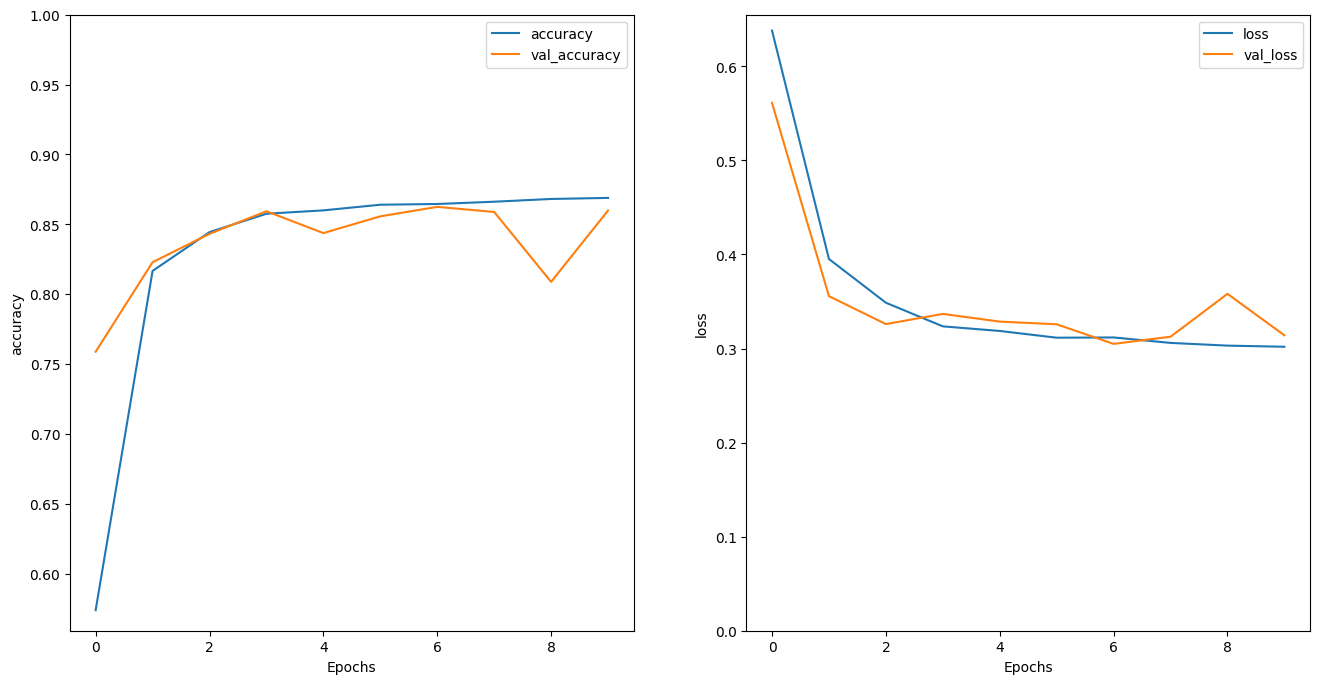

In [27]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.


Ejecute una predicción sobre una nueva oración:

Si la predicción es >= 0,0, es positiva; de lo contrario, es negativa.

In [28]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

ValueError: Invalid dtype: str3328

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/layered_bidirectional.png?raw=1)


Apila dos o más capas LSTM
Las capas recurrentes de Keras tienen dos modos disponibles que se controlan mediante el argumento del constructor return_sequences:

Si es Falso, devuelve solo la última salida para cada secuencia de entrada (un tensor 2D de forma (batch_size, output_features)). Este es el valor predeterminado, utilizado en el modelo anterior.

Si es Verdadero, se devuelven las secuencias completas de salidas sucesivas para cada paso de tiempo (un tensor 3D de forma (batch_size, timesteps, output_features)).

Así es como se ve el flujo de información con return_sequences=True:


The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

Lo interesante de usar una RNN con return_sequences=True es que la salida todavía tiene 3 ejes, como la entrada, por lo que se puede pasar a otra capa RNN, de esta manera:

In [29]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [30]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [31]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 48s 105ms/step - accuracy: 0.5113 - loss: 0.6854 - val_accuracy: 0.7953 - val_loss: 0.4385
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 42s 107ms/step - accuracy: 0.8192 - loss: 0.4116 - val_accuracy: 0.8536 - val_loss: 0.3294
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 80s 102ms/step - accuracy: 0.8486 - loss: 0.3499 - val_accuracy: 0.8708 - val_loss: 0.3053
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 102ms/step - accuracy: 0.8543 - loss: 0.3384 - val_accuracy: 0.8583 - val_loss: 0.3403
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 102ms/step - accuracy: 0.8569 - loss: 0.3298 - val_accuracy: 0.8630 - val_loss: 0.3192
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 103ms/step - accuracy: 0.8667 - loss: 0.3113 - val_accuracy: 0.8526 - val_loss: 0.3240
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 104ms/step - accuracy: 0.8687 - loss: 0.3082 - val_accuracy: 0.8667 - val_loss: 0.3040
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 102ms/step - accuracy: 0.8748 - loss: 0

In [32]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.8548 - loss: 0.3153
Test Loss: 0.3143373727798462
Test Accuracy: 0.8548399806022644


In [33]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

ValueError: Invalid dtype: str3296

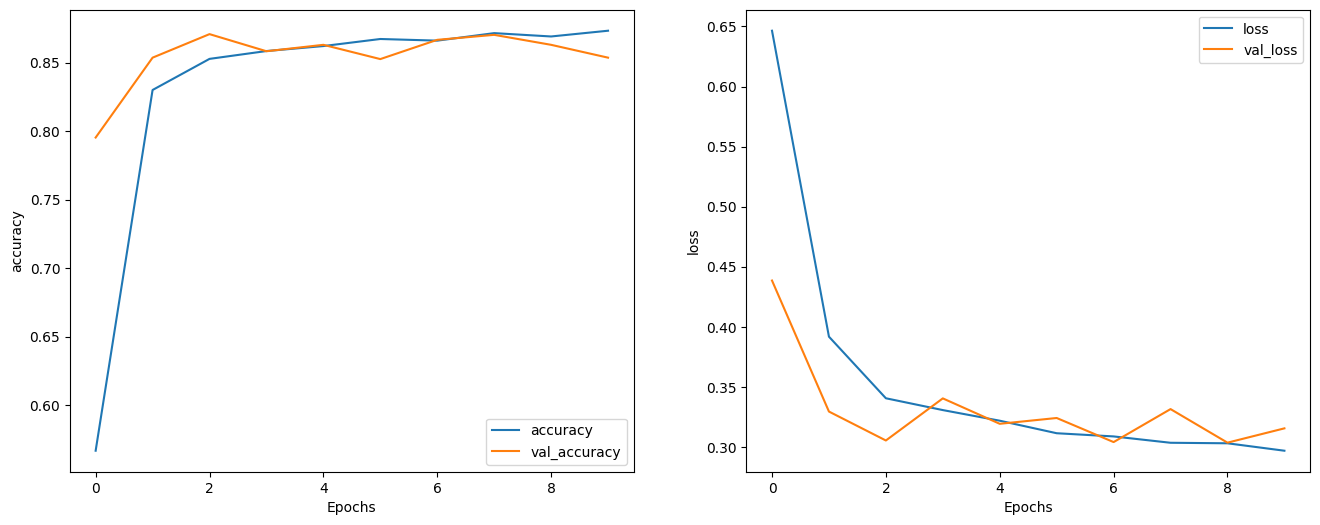

In [34]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interested in building custom RNNs, see the [Keras RNN Guide](https://www.tensorflow.org/guide/keras/rnn).


Consulta otras capas recurrentes existentes, como las capas GRU.

Si te interesa crear RNN personalizadas, consulta la Guía de RNN de Keras.